In [54]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import sqlite3
import sys
from typing import Tuple
import os
import operator
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Segur q es pot arreglar d"una altra forma
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import settings

# UTILS

## Dict

In [55]:
# Abreviatures extracted from https://laligafv.foroactivo.com/t5325-abreviaturas-de-los-equipos
team_names_3 = {
    "Alavés": "ALA",
    "Athletic": "ATH",
    "Atlético Madrid": "ATM",
    "Barcelona": "BAR",
    "CA Osasuna": "OSA",
    "Celta de Vigo": "CEL",
    "Cádiz CF": "CAD",
    "Elche CF": "ELC",
    "Getafe": "GET",
    "Granada CF": "GRA",
    "Levante": "LEV",
    "Real Betis": "BET",
    "Real Madrid": "RMA",
    "Real Sociedad": "RSO",
    "Real Valladolid": "VLL",
    "SD Eibar": "EIB",
    "SD Huesca": "HUE",
    "Sevilla FC": "SEV",
    "Valencia": "VAL",
    "Villarreal": "VIL",
    "FC Andorra": "FCA",
    "CF Badalona": "BDN",
    "CD Castellón": "CAS",
    "SD Eibar": "EIB",
    "Getafe FC": "GET",
    "Girona FC": "GIR",
    "Granada CF": "GRA",
    "Racing de Ferrol": "FER",
    "Racing de Santander": "RAC",
    "Rayo Vallecano": "RAY",
    "UP de Langreo": "UPL",
    "AD Alcorcón": "ALC",
    "Celta de Vigo": "CEL",
    "Deportivo Alavés": "ALA",
    "SD Huesca": "HUE",
    "UD Las Palmas": "LAS",
    "CD Leganés": "LEG",
    "Málaga CF": "MAL",
    "CA Osasuna": "OSA",
    "Real Avilés_CF": "RAI",
    "Real Jaén CF": "JAE",
    "Recreativo de Huelva": "REC",
    "Sporting de Gijón": "SPO",
    "Real Zaragoza": "ZAR",
    "UD Almeria": "ALM",
    "UD Almería": "ALM",
    "CD Badajoz": "BAD",
    "AD Ceuta": "CEU",
    "SD Compostela": "COM",
    "Dep. La Coruña": "DEP",
    "RCD Espanyol": "ESP",
    "Espanyol": "ESP",
    "Español": "ESP",
    "RCD Mallorca": "MLL",
    "SD Ponferradina": "SDP",
    "Real Betis": "BET",
    "Real Murcia CF": "MUR",
    "Real Oviedo": "OVI",
    "Real Sociedad": "RSO",
    "Real Valladolid": "VLL",
    "UE Sant Andreu": "SAN",
    "CD Tenerife": "TEN",
}

## Functions

In [56]:
def filter_season(df: DataFrame, season: str) -> DataFrame:
    """
    Filters and returns the matches within a specified season.

    :param df: DataFrame containing match data.
    :param season: Season where values will be extracted

    :return: DataFrame containing the matches within the specified season.
    """

    return df.loc[df["season"] == season]


def extract_season_values(
    df: DataFrame, season: str, column: str
) -> Tuple[DataFrame, DataFrame]:
    """
    Extracts and returns the counts of matches per weekday and per time within a specified season.

    :param df: DataFrame containing match data.
    :param season: Season where values will be extracted
    :param column: The column name to be used for extracting time values.

    :return: A tuple containing two DataFrames:
        - df_weekday: DataFrame with counts of matches per weekday.
        - df_time: DataFrame with counts of matches per time.
    """
    df_season = filter_season(df, season)

    df_weekday = df_season["date"].dt.day_name().value_counts().reset_index()
    df_weekday.columns = ["weekday", "count"]

    df_time = df_season[column].value_counts().reset_index()
    df_time.columns = ["time", "count"]
    return df_weekday, df_time

In [57]:
def won_games(df, team: str):
    """
    Returns those winning games for a given team
    """
    home_wins = (df["home_team"] == team) & (df["home_win"] == 1)
    away_wins = (df["away_team"] == team) & (df["away_win"] == 1)
    return df[home_wins | away_wins]


def lost_games(df, team: str):
    """
    Returns those winning games for a given team
    """
    home_lost = (df["home_team"] == team) & (df["home_win"] == 0)
    away_lost = (df["away_team"] == team) & (df["away_win"] == 0)
    tie_games = (df["home_team"] == team) & (df["tie"] == 1) | (
        df["away_team"] == team
    ) & (df["tie"] == 1)

    return df[(home_lost | away_lost) & ~tie_games]


def count_team_wins(df: DataFrame, team: str) -> int:
    """
    Count the number of wins for a specified team in a given DataFrame.
    """
    return won_games(df, team).shape[0]


def count_team_lost(df: DataFrame, team: str) -> int:
    """
    Count the number of lost for a specified team in a given DataFrame.
    """

    return lost_games(df, team).shape[0]


def count_team_goals(df: DataFrame, team: str) -> int:
    """
    Count the total number of goals scored by a specific team.

    :param df: The DataFrame containing match data.
    :type df: pd.DataFrame
    :param team: The name of the team for which to count the goals.
    :type team: str
    :return: The total number of goals scored by the team.
    :rtype: int
    """
    home_goals = df[df["home_team"] == team]
    away_goals = df[df["away_team"] == team]
    return home_goals["home_score"].sum() + away_goals["away_score"].sum()

# LOAD DATA

In [58]:
with sqlite3.connect(settings.DATABASE_PATH) as conn:
    df = pd.read_sql(
        f"""
            SELECT * FROM Matches
        """,
        conn,
    )

## Pretreatment

Date is provided as mm/dd/YY as there two centuries (1900/2000) the format mm/dd/YYYY will be used to more clear.

In [59]:
def adjust_date(row):
    """
    Adjust the date by adding the correct century based on the season.
    If the date"s year is less than the season"s end year, use the start year,
    otherwise use the end year of the season.

    :param row: A row from the DataFrame containing "date" and "season".
    :return: Adjusted date string in the format DD/MM/YYYY.
    """
    start_year = int(row["season"].split("-")[0])
    end_year = int(row["season"].split("-")[1])
    date_year = int(row["date"].split("/")[-1])

    if date_year == start_year % 100:
        return row["date"][:-2] + str(start_year)
    else:
        return row["date"][:-2] + str(end_year)


df["date"] = df.apply(adjust_date, axis=1)
df = df.dropna(subset=["date"])
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")

Pendent de veure amb que omplim els valors nuls

In [60]:
df = df.dropna(subset=["score"])

Creation of util columns that will be used commonly. 

In [61]:
df["home_score"] = df["score"].str.split(":").str[0].astype(int)
df["away_score"] = df["score"].str.split(":").str[1].astype(int)

In [62]:
df["home_win"] = (df["home_score"] > df["away_score"]).astype(int)
df["away_win"] = (df["home_score"] < df["away_score"]).astype(int)
df["tie"] = (df["home_score"] == df["away_score"]).astype(int)

## EX 1

In [63]:
home_wins = df["home_win"].sum()
away_wins = df["away_win"].sum()
ties = df["tie"].sum()

Text(0.5, 1.0, 'Match results')

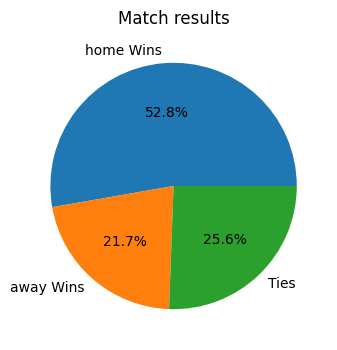

In [64]:
labels = ["home Wins", "away Wins", "Ties"]
sizes = [home_wins, away_wins, ties]

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct="%1.1f%%")

plt.title("Match results")

# Ex2

In [65]:
df_1 = df.loc[df["division"] == 1].copy()

In [66]:
scored_goals = (
    df_1.groupby("home_team")["home_score"].sum()
    + df_1.groupby("away_team")["away_score"].sum()
).sort_values(ascending=False)

top_10_scored = scored_goals[:10]

print(top_10_scored)

home_team
Barcelona          6267
Real Madrid        6249
Athletic           4802
Valencia           4615
Atlético Madrid    4184
Sevilla FC         3903
Espanyol           3720
Real Sociedad      3200
Real Zaragoza      2683
Celta de Vigo      2483
dtype: int64


In [67]:
conceded_goals = (
    df_1.groupby("home_team")["away_score"].sum()
    + df_1.groupby("away_team")["home_score"].sum()
).sort_values(ascending=False)

top_10_conceded = conceded_goals[:10]

print(top_10_conceded)

home_team
Espanyol           4034
Athletic           3875
Valencia           3649
Sevilla FC         3546
Real Madrid        3287
Barcelona          3259
Real Sociedad      3126
Atlético Madrid    2894
Celta de Vigo      2856
Real Zaragoza      2847
dtype: int64


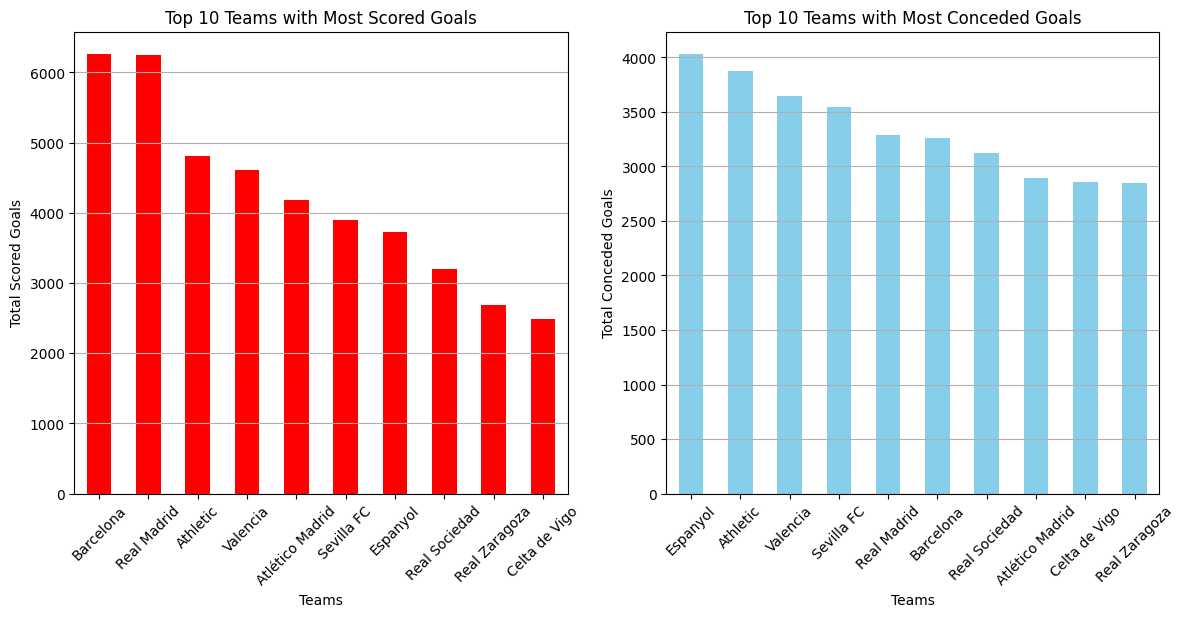

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

top_10_scored.plot(kind="bar", color="red", ax=axs[0])
axs[0].set_title("Top 10 Teams with Most Scored Goals")
axs[0].set_xlabel("Teams")
axs[0].set_ylabel("Total Scored Goals")
axs[0].set_xticklabels(top_10_scored.index, rotation=45)
axs[0].grid(axis="y")

top_10_conceded.plot(kind="bar", color="skyblue", ax=axs[1])
axs[1].set_title("Top 10 Teams with Most Conceded Goals")
axs[1].set_xlabel("Teams")
axs[1].set_ylabel("Total Conceded Goals")
axs[1].set_xticklabels(top_10_conceded.index, rotation=45)
axs[1].grid(axis="y")

In [69]:
df_1["difference_score"] = df_1["home_score"] - df_1["away_score"]
df_1["abs_difference_score"] = df_1["difference_score"].abs()
df_1.sort_values("abs_difference_score", ascending=False).head(10)[
    ["home_team", "away_team", "score"]
]

,home_team,away_team,score
225,Athletic,Barcelona,12:1
1071,Sevilla FC,Real Oviedo,10:0
936,Sevilla FC,Barcelona,11:1
1168,Athletic,Celta de Vigo,10:0
2787,Athletic,Lérida,10:0
6,Athletic,Espanyol,9:0
2537,Barcelona,Gimnàstic,10:1
408,Racing,Alavés,9:0
2771,Dep. La Coruña,Lérida,10:1
2969,Athletic,Real Zaragoza,10:1


# EX3

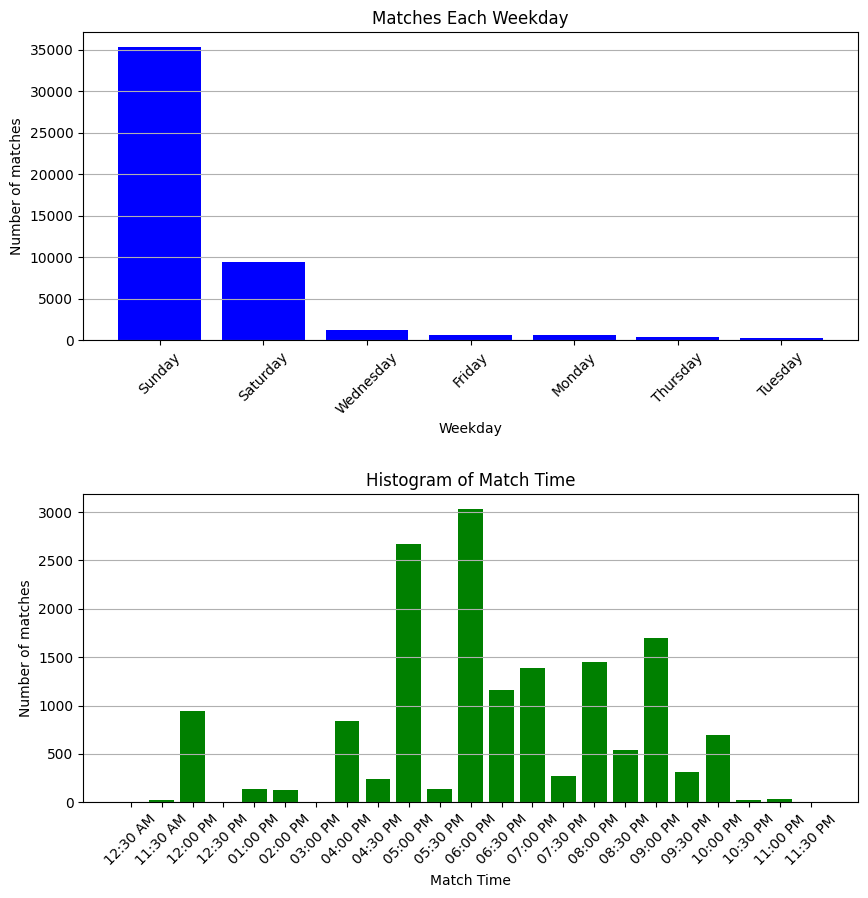

In [70]:
df_weekday = df["date"].dt.day_name().value_counts()
df_time = df["time"].value_counts()

df_weekday = df_weekday.reset_index()
df_weekday.columns = ["weekday", "count"]

df_time = df_time.reset_index()
df_time.columns = ["time", "count"]


def round_down_minutes(dt):
    if dt.minute in [0, 29]:
        return dt.replace(minute=0)
    else:
        return dt.replace(minute=30)


df_time["time"] = pd.to_datetime(df_time["time"], format="%I:%M %p")
df_time["time"] = df_time["time"].apply(round_down_minutes)

df_time = df_time.sort_values(by="time")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].bar(df_weekday["weekday"], df_weekday["count"], color="blue")
axes[0].set_title("Matches Each Weekday")
axes[0].set_xlabel("Weekday")
axes[0].set_ylabel("Number of matches")
axes[0].set_xticks(range(len(df_weekday["weekday"])))
axes[0].set_xticklabels(df_weekday["weekday"], rotation=45)
axes[0].grid(axis="y")

axes[1].bar(df_time["time"].dt.strftime("%I:%M %p"), df_time["count"], color="green")
axes[1].set_title("Histogram of Match Time")
axes[1].set_xlabel("Match Time")
axes[1].set_ylabel("Number of matches")
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(axis="y")

plt.subplots_adjust(hspace=0.5)

plt.show()

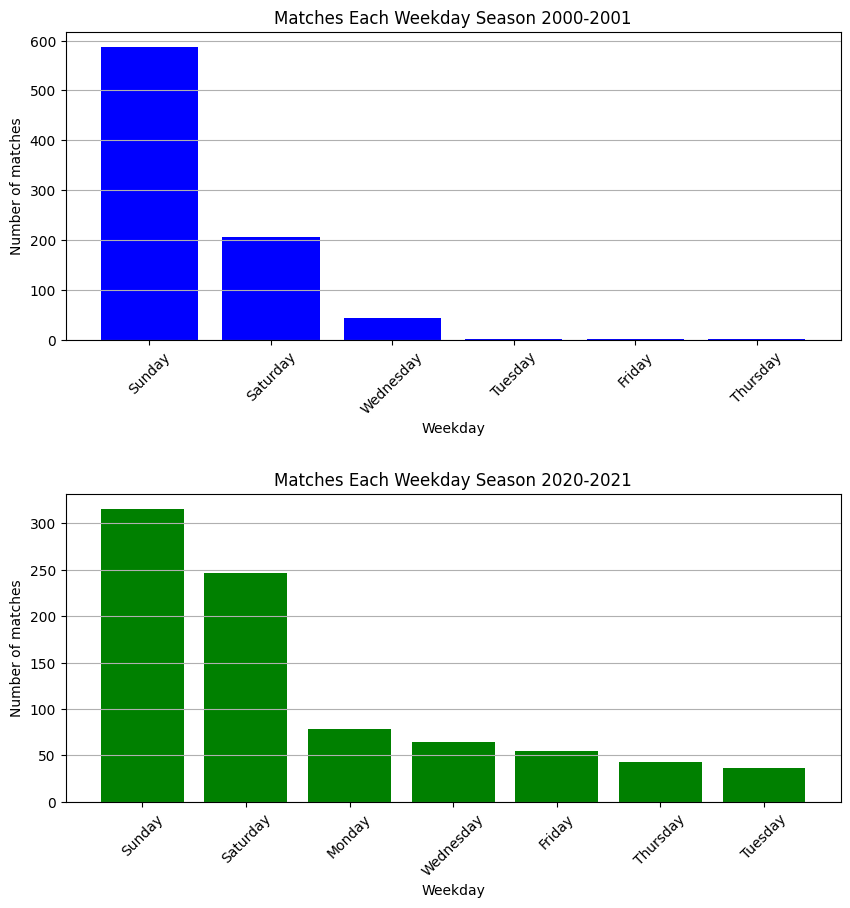

In [71]:
df_weekday_2000, df_time_2000 = extract_season_values(df, "2000-2001", "date")
df_weekday_2020, df_time_2020 = extract_season_values(df, "2020-2021", "date")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].bar(df_weekday_2000["weekday"], df_weekday_2000["count"], color="blue")
axes[0].set_title("Matches Each Weekday Season 2000-2001")
axes[0].set_xlabel("Weekday")
axes[0].set_ylabel("Number of matches")
axes[0].set_xticks(range(len(df_weekday_2000["weekday"])))
axes[0].set_xticklabels(df_weekday_2000["weekday"], rotation=45)
axes[0].grid(axis="y")

axes[1].bar(df_weekday_2020["weekday"], df_weekday_2020["count"], color="green")
axes[1].set_title("Matches Each Weekday Season 2020-2021")
axes[1].set_xlabel("Weekday")
axes[1].set_ylabel("Number of matches")
axes[1].set_xticks(range(len(df_weekday_2020["weekday"])))
axes[1].set_xticklabels(df_weekday_2020["weekday"], rotation=45)
axes[1].grid(axis="y")

plt.subplots_adjust(hspace=0.5)

plt.show()

# EX4

In [72]:
def highlight_wins(val):
    if isinstance(val, str):
        val = int(val.split(":")[0]) - int(val.split(":")[1])
    if val > 0:
        intensity = min(val / 10, 1)
        return f"background-color: rgba(0, 255, 0, {intensity})"
    elif val < 0:
        intensity = min(-val / 10, 1)
        return f"background-color: rgba(255, 0, 0, {intensity})"
    elif val == 0:
        intensity = 0.5
        return f"background-color: rgba(255, 255, 0, {intensity})"
    elif val == "":
        return f"background-color: rgba(255, 255, 255, 1)"
    return ""

In [73]:
df_2020 = filter_season(df_1, "2020-2021")

cross_table = pd.crosstab(
    df_2020["home_team"], df_2020["away_team"], values=df_2020["score"], aggfunc="sum"
)

cross_table = cross_table.rename(columns=team_names_3)

cross_table.index.name = None
cross_table.columns.name = "Home & Away"

cross_table = cross_table.style.applymap(highlight_wins)

cross_table

/tmp/ipykernel_153354/2578740406.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  cross_table = cross_table.style.applymap(highlight_wins)


Home & Away,ALA,ATH,ATM,BAR,OSA,CEL,CAD,ELC,GET,GRA,LEV,BET,RMA,RSO,VLL,EIB,HUE,SEV,VAL,VIL
Alavés,nan,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,nan,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,nan,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,nan,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,nan,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,nan,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,nan,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,nan,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,nan,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3
Granada CF,2:1,2:0,1:2,0:4,2:0,0:0,0:1,2:1,0:0,nan,1:1,2:0,1:4,1:0,1:3,4:1,3:3,1:0,2:1,0:3


In [74]:
def plot_cross_results_table(season, division):
    df_table = df.loc[(df["division"] == division) & (df["season"] == season)]

    cross_table = pd.crosstab(
        df_table["home_team"], df_table["away_team"], values=df_table["score"], aggfunc="sum"
    )

    cross_table = cross_table.rename(columns=team_names_3)

    cross_table.index.name = None
    cross_table.columns.name = "Home & Away"

    cross_table = cross_table.style.applymap(highlight_wins)

    return cross_table

In [75]:
plot_cross_results_table("2019-2020", 1)

/tmp/ipykernel_153354/2487514524.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  cross_table = cross_table.style.applymap(highlight_wins)


Home & Away,ALA,ATH,ATM,BAR,OSA,LEG,CEL,ESP,GET,GRA,LEV,MLL,BET,RMA,RSO,VLL,EIB,SEV,VAL,VIL
Alavés,nan,2:1,1:1,0:5,0:1,1:1,2:0,0:0,0:0,0:2,1:0,2:0,1:1,1:2,2:0,3:0,2:1,0:1,1:1,1:2
Athletic,2:0,nan,1:1,1:0,0:1,0:2,1:1,3:0,0:2,2:0,2:1,3:1,1:0,0:1,2:0,1:1,0:0,1:2,0:1,1:0
Atlético Madrid,2:1,2:0,nan,0:1,2:0,0:0,0:0,3:1,1:0,1:0,2:1,3:0,1:0,0:0,1:1,1:0,3:2,2:2,1:1,3:1
Barcelona,4:1,1:0,2:2,nan,1:2,2:0,4:1,1:0,2:1,1:0,2:1,5:2,5:2,0:0,1:0,5:1,5:0,4:0,5:2,2:1
CA Osasuna,4:2,1:2,0:5,2:2,nan,2:1,2:1,1:0,0:0,0:3,2:0,2:2,0:0,1:4,3:4,0:0,0:0,1:1,3:1,2:1
CD Leganés,1:1,1:1,0:1,1:2,0:1,nan,3:2,2:0,0:3,0:0,1:2,1:0,0:0,2:2,2:1,1:2,1:2,0:3,1:0,0:3
Celta de Vigo,6:0,1:0,1:1,2:2,1:1,1:0,nan,1:1,0:1,0:2,2:3,2:2,1:1,1:3,0:1,0:0,0:0,2:1,1:0,0:1
Espanyol,2:0,1:1,1:1,2:2,2:4,0:1,0:0,nan,1:1,0:3,1:3,1:0,2:2,0:1,1:3,0:2,0:2,0:2,1:2,0:1
Getafe,1:1,1:1,0:2,0:2,0:0,2:0,0:0,0:0,nan,3:1,4:0,4:2,1:0,0:3,2:1,2:0,1:1,0:3,3:0,1:3
Granada CF,3:0,4:0,1:1,2:0,1:0,1:0,0:0,2:1,2:1,nan,1:2,1:0,1:0,1:2,1:2,2:1,1:2,0:1,2:2,0:1


# EX5

In [76]:
def team_confrontations(df, team1, team2):
    df_confrontations = df.loc[
        ((df["home_team"] == team1) | (df["away_team"] == team1))
        & ((df["home_team"] == team2) | (df["away_team"] == team2))
    ]

    return df_confrontations

In [77]:
df_bm = team_confrontations(df, "Barcelona", "Real Madrid")
bcn_wins = count_team_wins(df_bm, "Barcelona")
mad_wins = count_team_wins(df_bm, "Real Madrid")
ties = df_bm["tie"].sum()
print(
    f"Barcelona has won {bcn_wins} games, while Real Madrid has won {mad_wins} games. There has been {ties} ties."
)

Barcelona has won 72 games, while Real Madrid has won 75 games. There has been 35 ties.


In [78]:
bcn_goals = count_team_goals(df_bm, "Barcelona")
mad_goals = count_team_goals(df_bm, "Real Madrid")

print(
    f"Barcelona has scored {bcn_goals} goals, while Real Madrid has scored {mad_goals} goals"
)

Barcelona has scored 290 goals, while Real Madrid has scored 293 goals


In [79]:
def plot_direct_confrontations_stats(df: DataFrame, team1: str, team2: str):
    """
    Plot the statistics of direct confrontations between two teams.

    :param df: The DataFrame containing match data.
    :type df: pd.DataFrame
    :param team1: The name of the first team.
    :type team1: str
    :param team2: The name of the second team.
    :type team2: str
    """
    if team1 not in team_names_3:
        raise ValueError(f"Team {team1} not found in the team names dictionary.")
    if team2 not in team_names_3:
        raise ValueError(f"Team {team2} not found in the team names dictionary.")

    df_confrontations = team_confrontations(df, team1, team2)
    team1_wins = count_team_wins(df_confrontations, team1)
    team2_wins = count_team_wins(df_confrontations, team2)
    ties = df_confrontations["tie"].sum()

    labels = [f"{team1} Wins", f"{team2} Wins", "Ties"]
    sizes = [team1_wins, team2_wins, ties]

    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%")

    plt.title("Match results")
    plt.show()

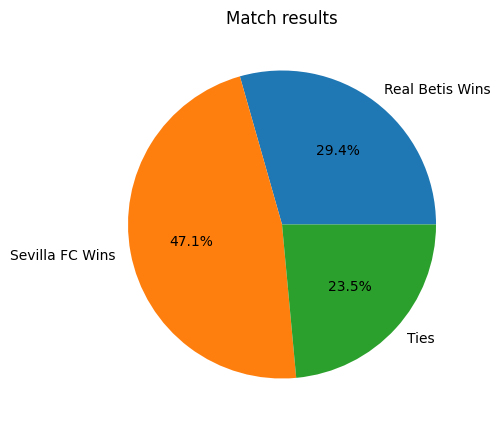

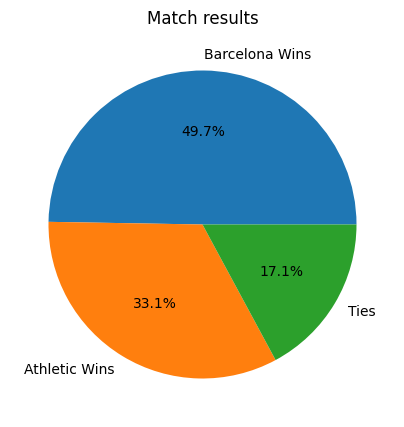

In [80]:
plot_direct_confrontations_stats(df, "Real Betis", "Sevilla FC")
plot_direct_confrontations_stats(df, "Barcelona", "Athletic")

# EX6

In [81]:
df_not_lose = df.copy()

df_not_lose['home_not_lose'] = df_not_lose['home_win'] | df_not_lose['tie']
df_not_lose['away_not_lose'] = df_not_lose['away_win'] | df_not_lose['tie']

home_results = df_not_lose[['date', 'home_team', 'home_not_lose']].rename(columns={'home_team': 'team', 'home_not_lose': 'not_lose'})
away_results = df_not_lose[['date', 'away_team', 'away_not_lose']].rename(columns={'away_team': 'team', 'away_not_lose': 'not_lose'})
results = pd.concat([home_results, away_results]).sort_values(by=['team', 'date']).reset_index(drop=True)

def unbeaten_streaks(results):
    streaks = [] 
    current_streak = 0
    start_index = None
    
    for i, not_lose in enumerate(results):
        if not_lose == 1:
            if current_streak == 0:
                start_index = i
            current_streak += 1
        else:
            if current_streak > 0:
                streaks.append((start_index, i - 1, current_streak))
            current_streak = 0

    if current_streak > 0:
        streaks.append((start_index, len(results) - 1, current_streak))
    return streaks

team_dates = results.groupby('team')['date'].apply(list).to_dict()

def find_date(team, index):
    if team in team_dates and index < len(team_dates[team]):
        return team_dates[team][index]
    return None

df_streaks = results.groupby('team')['not_lose'].apply(unbeaten_streaks).reset_index().explode('not_lose')
df_streaks['start'] = df_streaks.apply(lambda row: find_date(row['team'], row['not_lose'][0]) if len(row['not_lose']) > 0 else None, axis=1)
df_streaks['end'] = df_streaks.apply(lambda row: find_date(row['team'], row['not_lose'][0]) if len(row['not_lose']) > 0 else None, axis=1)
df_streaks['duration'] = df_streaks['not_lose'].apply(lambda x: x[2])
df_streaks.drop('not_lose', axis=1, inplace=True)
df_streaks


,team,start,end,duration
0,AD Almería,1979-09-16,1979-09-16,3
0,AD Almería,1979-10-21,1979-10-21,1
0,AD Almería,1979-11-04,1979-11-04,1
0,AD Almería,1979-11-18,1979-11-18,1
0,AD Almería,1979-12-02,1979-12-02,1
...,...,...,...,...
151,Écija Balompié,1997-01-19,1997-01-19,5
151,Écija Balompié,1997-03-02,1997-03-02,2
151,Écija Balompié,1997-03-29,1997-03-29,1
151,Écija Balompié,1997-04-13,1997-04-13,2


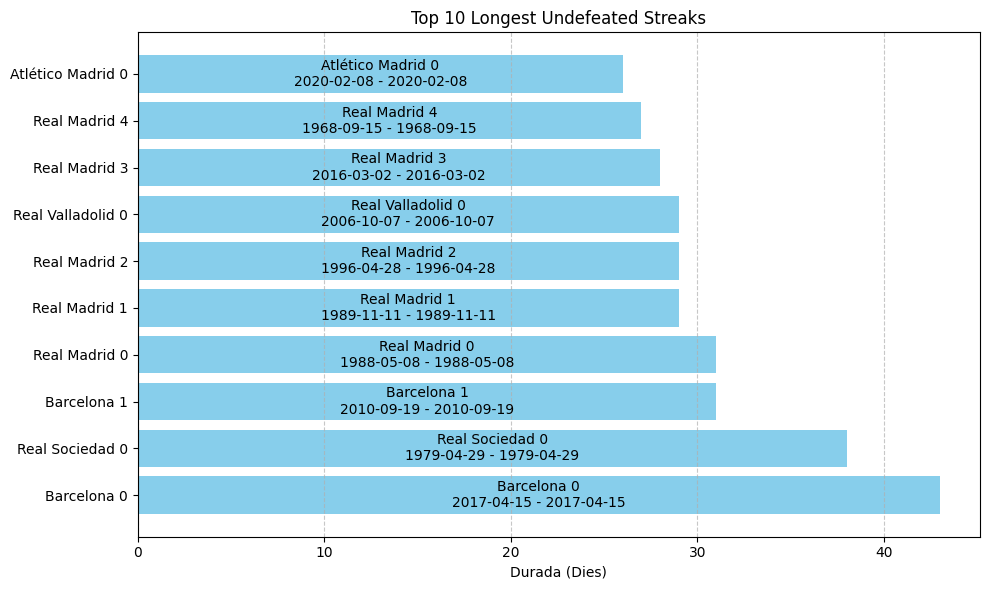

In [82]:

top_streaks = df_streaks.nlargest(10, 'duration')
top_streaks['team'] = top_streaks.groupby('team').cumcount().astype(str).radd(top_streaks['team'] + ' ')

plt.figure(figsize=(10, 6))
bars = plt.barh(top_streaks['team'], top_streaks['duration'], color='skyblue')

for bar, start, end in zip(bars, top_streaks['start'], top_streaks['end']):
    plt.text(
        bar.get_width() / 2,
        bar.get_y() + bar.get_height() / 2,
        f"{top_streaks['team'].iloc[bars.index(bar)]}\n{start.date()} - {end.date()}",
        va='center', 
        ha='center', 
        fontsize=10,
        color='black' 
    )

plt.xlabel('Durada (Dies)')
plt.title('Top 10 Longest Undefeated Streaks')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()





## EX 7

In [83]:
def calculate_team_results(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a DataFrame from a historic table of results to a final standings of each season and division.
    It is ordered by points per season. In case two teams have same number of points, is ordered by GD (de-
    scending), and then by GF (also descending).

    :param df: DataFrame containing match data for all teams.
    :return: DataFrame with results for each team and season.
    """

    df_results = (
        pd.concat(
            [
                df.groupby(["division", "season", "home_team"])
                .agg(
                    GF=("home_score", "sum"),
                    GA=("away_score", "sum"),
                    W=("home_win", "sum"),
                    L=("away_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"home_team": "team"}),
                df.groupby(["division", "season", "away_team"])
                .agg(
                    GF=("away_score", "sum"),
                    GA=("home_score", "sum"),
                    W=("away_win", "sum"),
                    L=("home_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"away_team": "team"}),
            ]
        )
        .groupby(["division", "season", "team"])
        .sum()
        .reset_index()
    )

    df_results["GD"] = df_results["GF"] - df_results["GA"]
    df_results["points"] = df_results["W"] * 3 + df_results["T"]

    df_results = df_results.sort_values(
        by=["division", "season", "points", "GD", "GF"],
        ascending=[True, False, False, False, False],
    ).reset_index(drop=True)

    df_results["rank"] = (
        df_results.groupby(["season", "division"])["points"]
        .rank("first", ascending=False)
        .astype(int)
    )

    df_results = df_results[
        [
            "season",
            "division",
            "rank",
            "team",
            "GF",
            "GA",
            "GD",
            "W",
            "L",
            "T",
            "points",
        ]
    ]
    return df_results


df_results = calculate_team_results(df)
# df_results.to_excel("../reports/SeasonStandings.xlsx", index=False) Descomentar si es vol generar
df_results

,season,division,rank,team,GF,GA,GD,W,L,T,points
0,2021-2022,1,1,Real Madrid,8,4,4,2,0,1,7
1,2021-2022,1,2,Sevilla FC,5,1,4,2,0,1,7
2,2021-2022,1,3,Valencia,5,1,4,2,0,1,7
3,2021-2022,1,4,Barcelona,7,4,3,2,0,1,7
4,2021-2022,1,5,Atlético Madrid,5,3,2,2,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...
2781,1932-1933,2,6,Real Gijón,50,40,10,8,8,2,26
2782,1932-1933,2,7,Celta de Vigo,37,38,-1,8,9,1,25
2783,1932-1933,2,8,CA Osasuna,46,47,-1,7,8,3,24
2784,1932-1933,2,9,Sevilla FC,29,38,-9,5,10,3,18


## EX 8

In [84]:
# PODER ES POT FER D"ALGUNA FORMA QUE NO S"HAGI DE FER CAP MERGE
division_1_season_counts = (
    df_results[df_results["division"] == 1]
    .groupby("season")
    .size()
    .reset_index(name="count")
)

df_results = pd.merge(df_results, division_1_season_counts, on="season", how="left")

df_results["extended rank"] = df_results["rank"]
df_results.loc[df_results["division"] == 2, "extended rank"] += df_results["count"]

df_results

,season,division,rank,team,GF,GA,GD,W,L,T,points,count,extended rank
0,2021-2022,1,1,Real Madrid,8,4,4,2,0,1,7,20,1
1,2021-2022,1,2,Sevilla FC,5,1,4,2,0,1,7,20,2
2,2021-2022,1,3,Valencia,5,1,4,2,0,1,7,20,3
3,2021-2022,1,4,Barcelona,7,4,3,2,0,1,7,20,4
4,2021-2022,1,5,Atlético Madrid,5,3,2,2,0,1,7,20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2781,1932-1933,2,6,Real Gijón,50,40,10,8,8,2,26,10,16
2782,1932-1933,2,7,Celta de Vigo,37,38,-1,8,9,1,25,10,17
2783,1932-1933,2,8,CA Osasuna,46,47,-1,7,8,3,24,10,18
2784,1932-1933,2,9,Sevilla FC,29,38,-9,5,10,3,18,10,19


ES POT MILLORAR I FER-LA MÉS MACA:

Fer les linies mes fines per q s"entengui millor

Separar la llegenda per info extra: 2a divisio, guerra civil

Eliminar linia 2a divisio durant guerra civil

Afegir docstrings

In [85]:
def standard_plot_config_teams_rank(ax, seasons):
    ax.plot(
        division_1_season_counts["season"][:8],
        division_1_season_counts["count"][:8], # Division for the civil war
        label="2nd division",
        linestyle="dashed",
        color='red'
    )
    ax.plot(
        division_1_season_counts["season"][8:],
        division_1_season_counts["count"][8:],
        linestyle="dashed",
        color='red'
    )

    ax.set_ylim(0, 40)
    ax.set_xlim("1928-1929", "2019-2020")

    ax.vlines(
        ["1935-1936", "1939-1940"],
        ymin=ax.get_ylim()[0],
        ymax=ax.get_ylim()[1],
        colors=["black", "black"],
        linestyles="dashed",
        linewidth=1,
    )

    ax.set_xlabel("Season", fontsize=10)
    ax.set_ylabel("Extended Rank", fontsize=10)
    ax.set_title("Ranking Evolution Over Seasons", fontsize=12)

    ax.set_xticks(range(0, len(seasons), 5))
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    ax.set_yticks(range(1, 41, 4))

    ax.invert_yaxis()

    vline1 = Line2D(
        [0], [0], color="black", linestyle="dashed", label="Civil War Interruption"
    )

    ax.legend(
        loc="center left", bbox_to_anchor=(1, 0.5), handles=ax.get_lines() + [vline1]
    )

    ax.grid(True)

/tmp/ipykernel_153354/1406813187.py:42: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(


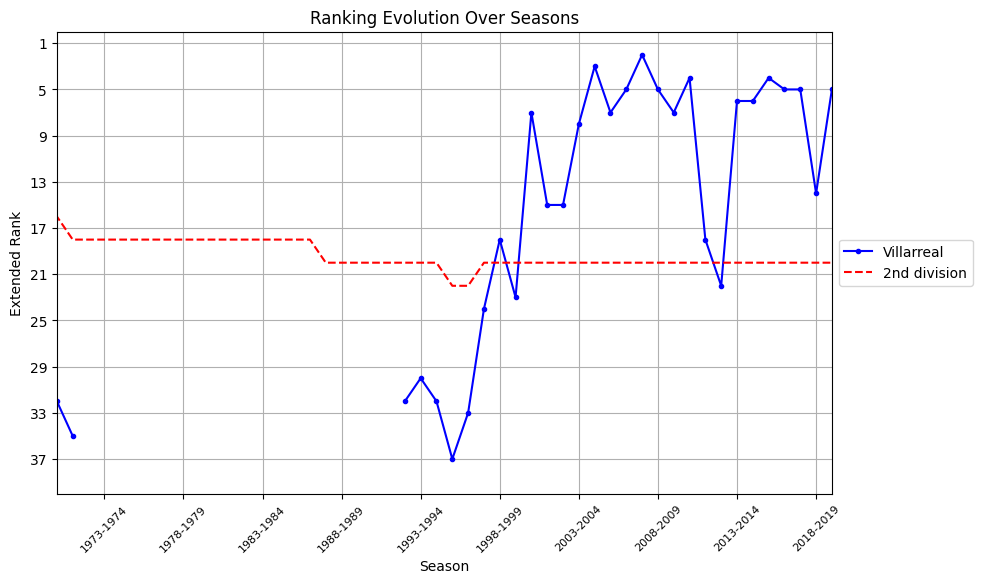

In [86]:
seasons = [f"{year}-{year+1}" for year in range(1928, 2021)]

villarreal_data = df_results[df_results["team"] == "Villarreal"][
    ["season", "division", "extended rank"]
]

# Reindex the DataFrame to include all seasons, filling missing values with NaN
villarreal_data = villarreal_data.set_index("season").reindex(seasons).reset_index()
villarreal_data.rename(columns={"index": "season"}, inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(villarreal_data["season"], villarreal_data["extended rank"], marker='.', color='blue', label="Villarreal")
standard_plot_config_teams_rank(ax, seasons)
ax.set_xlim("1970-1971", "2019-2020")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))



plt.show()

/tmp/ipykernel_153354/1406813187.py:42: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(


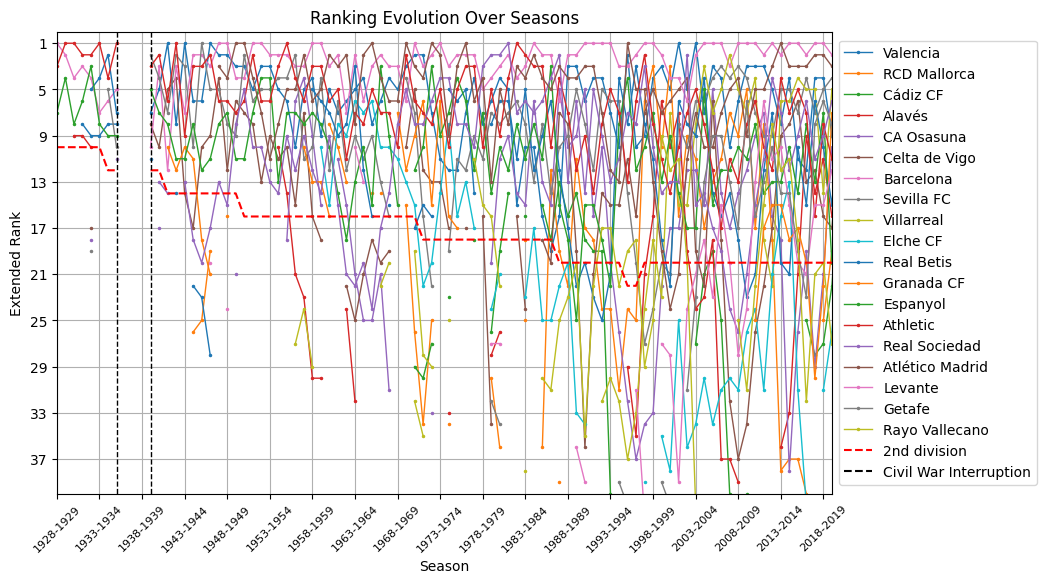

In [87]:
def plot_ranking_evolution(df, *teams):
    team_data = df_results[df_results["team"].isin(teams)][
        ["team", "season", "extended rank"]
    ]
    _, ax = plt.subplots(figsize=(10, 6))

    for team in teams:
        team_df = (
            team_data[team_data["team"] == team]
            .set_index("season")
            .reindex(seasons)
            .reset_index()
        )
        ax.plot(
            team_df["season"],
            team_df["extended rank"],
            label=team, linewidth=1,
            marker='.',
            markersize=3)

    standard_plot_config_teams_rank(ax, seasons)

    return plt


actual_1st_teams = df_1.loc[df_1["season"] == "2021-2022"]["home_team"].unique()

plot_ranking_evolution(df_results, *actual_1st_teams).show()

/tmp/ipykernel_153354/1406813187.py:42: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(


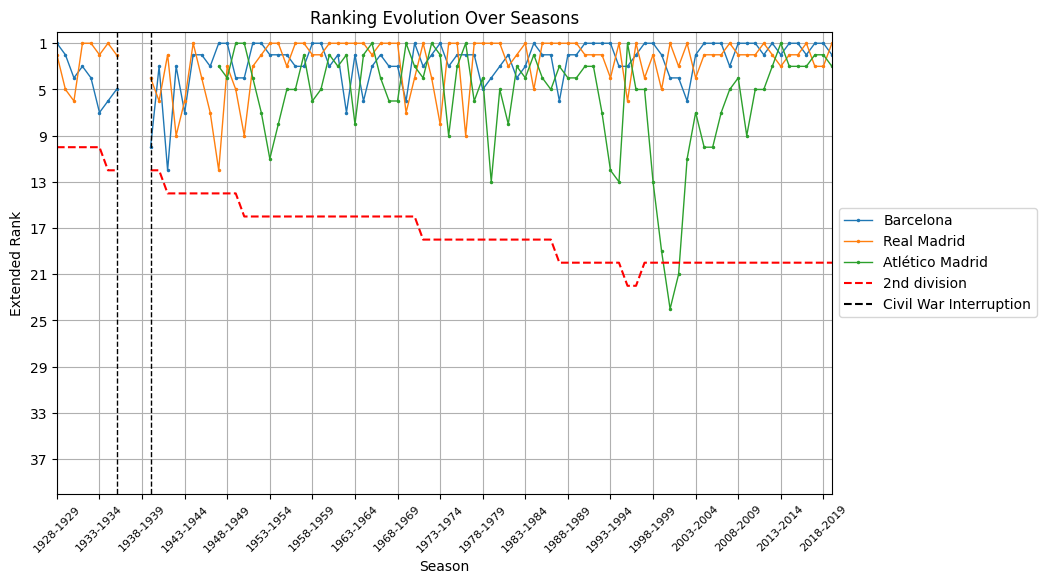

In [88]:
plot_ranking_evolution(df_results, "Barcelona", "Real Madrid", "Atlético Madrid").show()

## EX 9

/tmp/ipykernel_153354/1406813187.py:42: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(


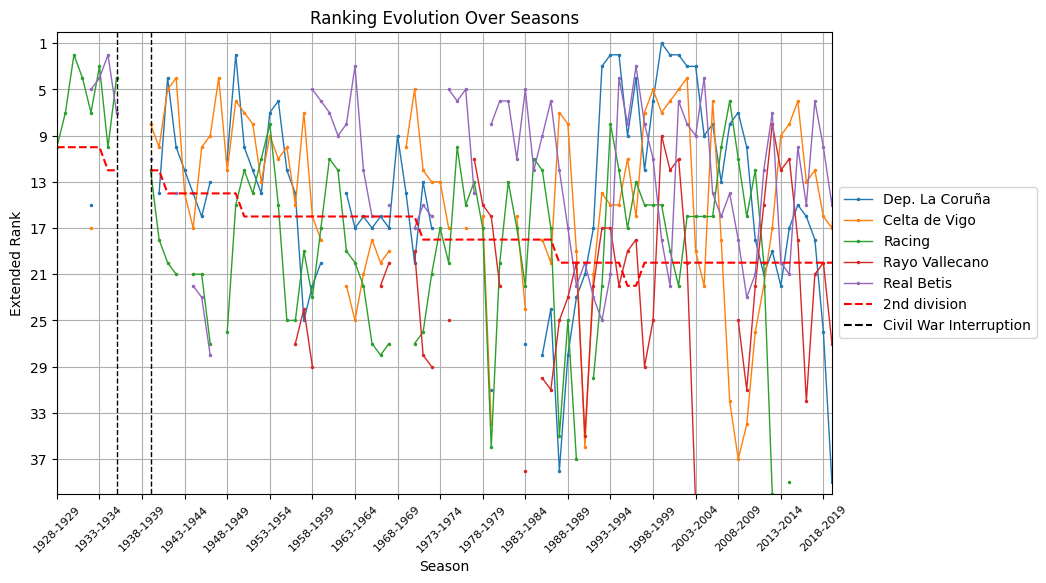

In [89]:
unique_teams = df_results["team"].unique()

team_data = df_results.loc[df_results["team"].isin(unique_teams)][
        ["team", "season", "division", "extended rank"]
    ].sort_values("season")

team_data["ascending/descending"] = (
        team_data.groupby("team")["division"]
        .transform(lambda x: (x != x.shift()).cumsum())
    )
elevators_by_team = team_data.groupby("team")["ascending/descending"].max().sort_values(ascending=False)

top_5_elev_teams = elevators_by_team.head(5).index.tolist()

plot_ranking_evolution(df, *top_5_elev_teams).show()

## EX 10

In [90]:
def calculate_team_results_matchday(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a DataFrame from a historic table of results to a final standings of each season and division.
    It is ordered by points per season. In case two teams have same number of points, is ordered by GD (de-
    scending), and then by GF (also descending).

    :param df: DataFrame containing match data for all teams.
    :return: DataFrame with results for each team and season.
    """

    df_results = (
        pd.concat(
            [
                df.groupby(["division", "season", "home_team", "matchday"])
                .agg(
                    GF=("home_score", "sum"),
                    GA=("away_score", "sum"),
                    W=("home_win", "sum"),
                    L=("away_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"home_team": "team"}),
                df.groupby(["division", "season", "away_team", "matchday"])
                .agg(
                    GF=("away_score", "sum"),
                    GA=("home_score", "sum"),
                    W=("away_win", "sum"),
                    L=("home_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"away_team": "team"}),
            ]
        )
        .groupby(["division", "season", "team", "matchday"])
        .sum()
        .reset_index()
    )

    df_results["GD"] = df_results["GF"] - df_results["GA"]
    df_results["points"] = df_results["W"] * 3 + df_results["T"]

    df_results = df_results.sort_values(
        by=["division", "season", "matchday", "points", "GD", "GF"],
        ascending=[True, False, False, False, False, False],
    ).reset_index(drop=True)

    df_results["rank"] = (
        df_results.groupby(["season", "division", "matchday"])["points"]
        .rank("first", ascending=False)
        .astype(int)
    )

    df_results = df_results[
        [
            "season",
            "division",
            "matchday",
            "rank",
            "team",
            "GF",
            "GA",
            "GD",
            "W",
            "L",
            "T",
            "points",
        ]
    ]
    return df_results


df_results_matchday = calculate_team_results_matchday(df)
#df_results_matchday.to_excel("../reports/MatchdayStandings.xlsx", index=False)
df_results_matchday

,season,division,matchday,rank,team,GF,GA,GD,W,L,T,points
0,2021-2022,1,3,1,Rayo Vallecano,4,0,4,1,0,0,3
1,2021-2022,1,3,2,Valencia,3,0,3,1,0,0,3
2,2021-2022,1,3,3,CA Osasuna,3,2,1,1,0,0,3
3,2021-2022,1,3,4,Barcelona,2,1,1,1,0,0,3
4,2021-2022,1,3,5,Athletic,1,0,1,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
95989,1932-1933,2,1,6,Dep. La Coruña,0,0,0,0,0,1,1
95990,1932-1933,2,1,7,CA Osasuna,1,2,-1,0,1,0,0
95991,1932-1933,2,1,8,Real Unión,2,4,-2,0,1,0,0
95992,1932-1933,2,1,9,Real Gijón,2,5,-3,0,1,0,0


In [91]:
df_results

,season,division,rank,team,GF,GA,GD,W,L,T,points,count,extended rank
0,2021-2022,1,1,Real Madrid,8,4,4,2,0,1,7,20,1
1,2021-2022,1,2,Sevilla FC,5,1,4,2,0,1,7,20,2
2,2021-2022,1,3,Valencia,5,1,4,2,0,1,7,20,3
3,2021-2022,1,4,Barcelona,7,4,3,2,0,1,7,20,4
4,2021-2022,1,5,Atlético Madrid,5,3,2,2,0,1,7,20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2781,1932-1933,2,6,Real Gijón,50,40,10,8,8,2,26,10,16
2782,1932-1933,2,7,Celta de Vigo,37,38,-1,8,9,1,25,10,17
2783,1932-1933,2,8,CA Osasuna,46,47,-1,7,8,3,24,10,18
2784,1932-1933,2,9,Sevilla FC,29,38,-9,5,10,3,18,10,19


In [93]:
df_results

,season,division,rank,team,GF,GA,GD,W,L,T,points,count,extended rank,result
0,2021-2022,1,1,Real Madrid,8,4,4,2,0,1,7,20,1,T
1,2021-2022,1,2,Sevilla FC,5,1,4,2,0,1,7,20,2,T
2,2021-2022,1,3,Valencia,5,1,4,2,0,1,7,20,3,T
3,2021-2022,1,4,Barcelona,7,4,3,2,0,1,7,20,4,T
4,2021-2022,1,5,Atlético Madrid,5,3,2,2,0,1,7,20,5,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2781,1932-1933,2,6,Real Gijón,50,40,10,8,8,2,26,10,16,T
2782,1932-1933,2,7,Celta de Vigo,37,38,-1,8,9,1,25,10,17,T
2783,1932-1933,2,8,CA Osasuna,46,47,-1,7,8,3,24,10,18,T
2784,1932-1933,2,9,Sevilla FC,29,38,-9,5,10,3,18,10,19,T


In [95]:


# Crea una columna amb el resultat de cada partit com a text
df_results['result'] = np.where(df_results['W'] == 1, 'W', np.where(df_results['L'] == 1, 'L', 'T'))

# Aplica `rolling` als últims 5 resultats, evitant incompatibilitats d'índex
df_results['last_5_results'] = (
    df_results.groupby(['team', 'season'])['result']
    .apply(lambda x: x.shift().rolling(5, min_periods=1).apply(lambda s: list(s), raw=False))
    .reset_index(level=[0, 1], drop=True)
)
df_results


,season,division,rank,team,GF,GA,GD,W,L,T,points,count,extended rank,result,last_5_results
0,2021-2022,1,1,Real Madrid,8,4,4,2,0,1,7,20,1,T,NaN
1,2021-2022,1,2,Sevilla FC,5,1,4,2,0,1,7,20,2,T,NaN
2,2021-2022,1,3,Valencia,5,1,4,2,0,1,7,20,3,T,NaN
3,2021-2022,1,4,Barcelona,7,4,3,2,0,1,7,20,4,T,NaN
4,2021-2022,1,5,Atlético Madrid,5,3,2,2,0,1,7,20,5,T,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2781,1932-1933,2,6,Real Gijón,50,40,10,8,8,2,26,10,16,T,NaN
2782,1932-1933,2,7,Celta de Vigo,37,38,-1,8,9,1,25,10,17,T,NaN
2783,1932-1933,2,8,CA Osasuna,46,47,-1,7,8,3,24,10,18,T,NaN
2784,1932-1933,2,9,Sevilla FC,29,38,-9,5,10,3,18,10,19,T,NaN


In [ ]:
def get_last_5_results(df, team, season):
    df_team_season = df[(df["home_team"] == team) | (df["away_team"] == team)]
    df_team_season = df_team_season[df_team_season["season"] == season]

    df_team_season["Result"] = np.where(
        (df_team_season["home_team"] == team) & (df_team_season["home_win"] == 1)
        | (df_team_season["away_team"] == team) & (df_team_season["away_win"] == 1),
        "W",
        np.where(
            (df_team_season["home_team"] == team) & (df_team_season["home_win"] == 0)
            | (df_team_season["away_team"] == team) & (df_team_season["away_win"] == 0),
            "L",
            "T",
        ),
    )

    last_5_results = (
        df_team_season.sort_values("date", ascending=False)["Result"].head(5).tolist()
    )
    return f"{last_5_results}"


df_results_extended = df_results_matchday.copy()
df_results_extended["last5"] = df_results_extended.apply(
    lambda row: get_last_5_results(df, row["team"], row["season"]), axis=1
)
#df_results_extended.to_excel("../reports/MatchdayStandings.xlsx", index=False)
df_results_extended

KeyboardInterrupt: 

Aquest es un càlcul que podem paral·litzar. Com hem vist a Parallel Programming, com que tenim un loop on el resultat de la funció és independent de cada iteracció, en aquest cas es beneficios aplicar-ho.
En python tenim ProcessPoolExecutor.

D'aquesta forma el codi s'executa quasi 4 cops més ràpid.

In [ ]:
df_results

,season,division,rank,team,GF,GA,GD,W,L,T,points,count,extended rank
0,2021-2022,1,1,Real Madrid,8,4,4,2,0,1,7,20,1
1,2021-2022,1,2,Sevilla FC,5,1,4,2,0,1,7,20,2
2,2021-2022,1,3,Valencia,5,1,4,2,0,1,7,20,3
3,2021-2022,1,4,Barcelona,7,4,3,2,0,1,7,20,4
4,2021-2022,1,5,Atlético Madrid,5,3,2,2,0,1,7,20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2781,1932-1933,2,6,Real Gijón,50,40,10,8,8,2,26,10,16
2782,1932-1933,2,7,Celta de Vigo,37,38,-1,8,9,1,25,10,17
2783,1932-1933,2,8,CA Osasuna,46,47,-1,7,8,3,24,10,18
2784,1932-1933,2,9,Sevilla FC,29,38,-9,5,10,3,18,10,19


In [ ]:
df_results_matchday

,season,division,matchday,rank,team,GF,GA,GD,W,L,T,points
0,2021-2022,1,3,1,Rayo Vallecano,4,0,4,1,0,0,3
1,2021-2022,1,3,2,Valencia,3,0,3,1,0,0,3
2,2021-2022,1,3,3,CA Osasuna,3,2,1,1,0,0,3
3,2021-2022,1,3,4,Barcelona,2,1,1,1,0,0,3
4,2021-2022,1,3,5,Athletic,1,0,1,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
95989,1932-1933,2,1,6,Dep. La Coruña,0,0,0,0,0,1,1
95990,1932-1933,2,1,7,CA Osasuna,1,2,-1,0,1,0,0
95991,1932-1933,2,1,8,Real Unión,2,4,-2,0,1,0,0
95992,1932-1933,2,1,9,Real Gijón,2,5,-3,0,1,0,0


In [ ]:
from concurrent.futures import ProcessPoolExecutor

df_results_extended = df_results_matchday.copy()


def get_last_5_results_for_row(row):
    return get_last_5_results(df, row["team"], row["season"])


with ProcessPoolExecutor(
    max_workers=8
) as executor:  # 8 és número òptim per al meu ordinador
    df_results_extended["last5"] = list(
        executor.map(
            get_last_5_results_for_row,
            [row for _, row in df_results_extended.iterrows()],
        )
    )
df_results_extended

,season,division,matchday,rank,team,GF,GA,GD,W,L,T,points,last5
0,2021-2022,1,3,1,Rayo Vallecano,4,0,4,1,0,0,3,"['W', 'L', 'L']"
1,2021-2022,1,3,2,Valencia,3,0,3,1,0,0,3,"['W', 'L', 'W']"
2,2021-2022,1,3,3,CA Osasuna,3,2,1,1,0,0,3,"['W', 'L', 'L']"
3,2021-2022,1,3,4,Barcelona,2,1,1,1,0,0,3,"['W', 'L', 'W']"
4,2021-2022,1,3,5,Athletic,1,0,1,1,0,0,3,"['W', 'L', 'L']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95989,1932-1933,2,1,6,Dep. La Coruña,0,0,0,0,0,1,1,"['L', 'L', 'W', 'W', 'W']"
95990,1932-1933,2,1,7,CA Osasuna,1,2,-1,0,1,0,0,"['W', 'W', 'L', 'L', 'W']"
95991,1932-1933,2,1,8,Real Unión,2,4,-2,0,1,0,0,"['L', 'L', 'W', 'W', 'L']"
95992,1932-1933,2,1,9,Real Gijón,2,5,-3,0,1,0,0,"['L', 'W', 'W', 'L', 'L']"
